In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

In [2]:
(train_data, test_data), ds_info = tfds.load(name="emnist/digits",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/240000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/digits/3.0.0.incompleteK4KRPY/emnist-train.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/40000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/digits/3.0.0.incompleteK4KRPY/emnist-test.tfrecord*...:   0%|      …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/digits/3.0.0. Subsequent calls will reuse this data.


In [3]:
train_data = train_data.concatenate(test_data)

In [4]:
dataset = []
label_var = []
for image, label in tfds.as_numpy(train_data):
  if label not in label_var: label_var.append(label)
  dataset.append(dict({
      'image' : image,
      'label' : int(label)
  }))

In [5]:
print(label_var)

[8, 3, 6, 2, 5, 4, 1, 0, 9, 7]


In [6]:
import random

rand = []

while len(rand) < 3:
  num = random.randint(0,9)
  if num not in rand: rand.append(num)

print(rand)

[2, 9, 6]


In [7]:
dataset_per_label = []
for label in label_var:
  dataset_per_label.append([])

for number in dataset:
  dataset_per_label[number['label']].append(number)


data = []
i = 0
for label in dataset_per_label:
  if i == 0:
    num = int(len(label) * 50 / 100)
    data.append(np.random.choice(label, num, replace=False))
  elif i == 2:
    num = int(len(label) * 60 / 100)
    data.append(np.random.choice(label, num, replace=False))
  elif i == 7:
    num = int(len(label) * 70 / 100)
    data.append(np.random.choice(label, num, replace=False))
  else:
    data.append(label)
  i += 1

for i in range(len(data)):
  print(i, len(data[i]))

0 14000
1 28000
2 16800
3 28000
4 28000
5 28000
6 28000
7 19600
8 28000
9 28000


In [8]:
new_data = []
for d in data:
  for singular in d:
    new_data.append(singular)

print(new_data[0]['label'])

0


In [9]:
print(type(new_data[0]))

<class 'dict'>


In [10]:
X = []
Y = []
for i in range(len(new_data)):
  X.append(tf.cast(new_data[i]['image'], tf.float32) / 255)
  Y.append(tf.one_hot(new_data[i]['label'], depth=10))

X = np.array(X)
Y = np.array(Y)

In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [13]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(28,28,1)),
        keras.layers.Conv2D(96, kernel_size=(3,3), strides=(1,1), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(256, kernel_size=(5,5), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 384)         1

In [14]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [15]:
history_alexnet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10
12320/12320 [==============================] - 206s 16ms/step - loss: 0.1174 - accuracy: 0.9704 - val_loss: 0.0456 - val_accuracy: 0.9891
Epoch 2/10
12320/12320 [==============================] - 194s 16ms/step - loss: 0.0715 - accuracy: 0.9846 - val_loss: 0.0547 - val_accuracy: 0.9881
Epoch 3/10
12320/12320 [==============================] - 193s 16ms/step - loss: 0.0691 - accuracy: 0.9854 - val_loss: 0.0588 - val_accuracy: 0.9858
Epoch 4/10
12320/12320 [==============================] - 194s 16ms/step - loss: 0.0719 - accuracy: 0.9850 - val_loss: 0.0544 - val_accuracy: 0.9897
Epoch 5/10
12320/12320 [==============================] - 194s 16ms/step - loss: 0.0738 - accuracy: 0.9844 - val_loss: 0.0515 - val_accuracy: 0.9888
Epoch 6/10
12320/12320 [==============================] - 203s 16ms/step - loss: 0.0747 - accuracy: 0.9844 - val_loss: 0.0830 - val_accuracy: 0.9817
Epoch 7/10
12320/12320 [==============================] - 194s 16ms/step - loss: 0.0758 - accuracy: 0.9836

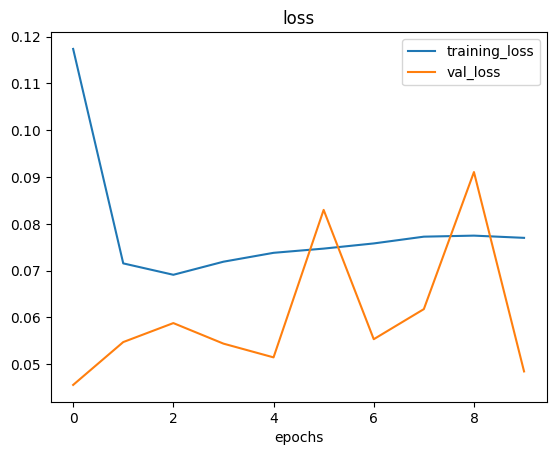

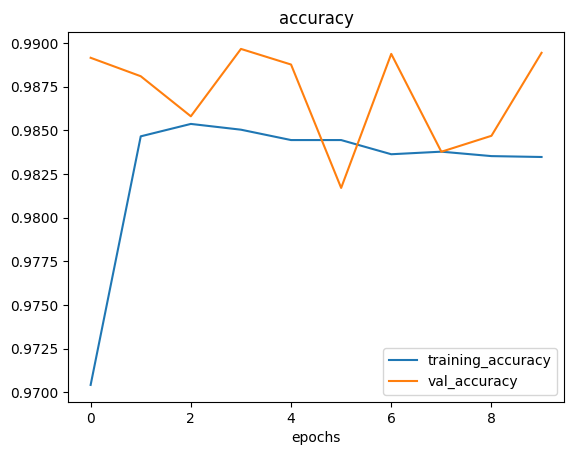

In [16]:
plot_loss_curves(history_alexnet)

In [17]:
model = keras.models.Sequential(
    [
      keras.layers.Input((28,28,1)),
      keras.layers.Conv2D(6, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='sigmoid'),
      keras.layers.Dense(84, activation='sigmoid'),
      keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [18]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
history_lenet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10
12320/12320 [==============================] - 76s 6ms/step - loss: 0.1983 - accuracy: 0.9380 - val_loss: 0.0481 - val_accuracy: 0.9855
Epoch 2/10
12320/12320 [==============================] - 60s 5ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0349 - val_accuracy: 0.9892
Epoch 3/10
12320/12320 [==============================] - 57s 5ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0358 - val_accuracy: 0.9893
Epoch 4/10
12320/12320 [==============================] - 56s 5ms/step - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.0315 - val_accuracy: 0.9906
Epoch 5/10
12320/12320 [==============================] - 62s 5ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0294 - val_accuracy: 0.9917
Epoch 6/10
12320/12320 [==============================] - 60s 5ms/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.0252 - val_accuracy: 0.9926
Epoch 7/10
12320/12320 [==============================] - 55s 4ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0

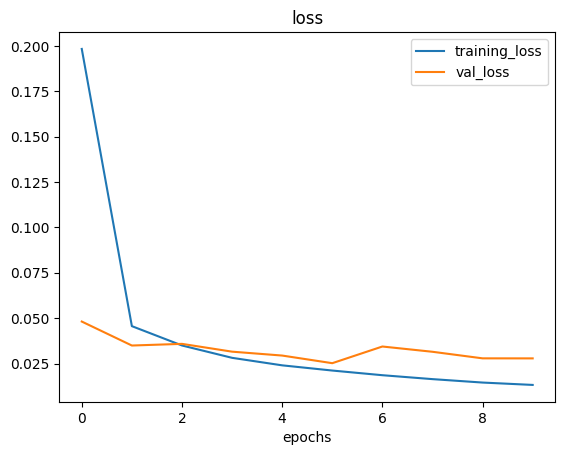

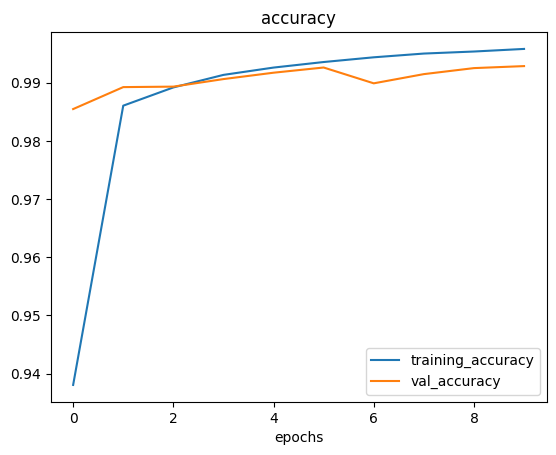

In [20]:
plot_loss_curves(history_lenet)

Custom

In [21]:
model = keras.models.Sequential(
    [
      keras.layers.Input((28,28,1)),

      keras.layers.Conv2D(6, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.Conv2D(12, kernel_size=(5,5), activation='sigmoid', padding='same'),

      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='sigmoid', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='sigmoid', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='sigmoid', padding='same'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),

      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='sigmoid'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(84, activation='sigmoid'),

      keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 12)        1812      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 12)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 16)        4816      
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        9248      
                                                      

In [22]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [23]:
history_custom = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10
12320/12320 [==============================] - 81s 6ms/step - loss: 0.4716 - accuracy: 0.8351 - val_loss: 0.0554 - val_accuracy: 0.9835
Epoch 2/10
12320/12320 [==============================] - 73s 6ms/step - loss: 0.0630 - accuracy: 0.9823 - val_loss: 0.0374 - val_accuracy: 0.9895
Epoch 3/10
12320/12320 [==============================] - 77s 6ms/step - loss: 0.0466 - accuracy: 0.9870 - val_loss: 0.0268 - val_accuracy: 0.9926
Epoch 4/10
12320/12320 [==============================] - 75s 6ms/step - loss: 0.0379 - accuracy: 0.9893 - val_loss: 0.0284 - val_accuracy: 0.9924
Epoch 5/10
12320/12320 [==============================] - 74s 6ms/step - loss: 0.0325 - accuracy: 0.9910 - val_loss: 0.0228 - val_accuracy: 0.9937
Epoch 6/10
12320/12320 [==============================] - 78s 6ms/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 0.0249 - val_accuracy: 0.9930
Epoch 7/10
12320/12320 [==============================] - 78s 6ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 0

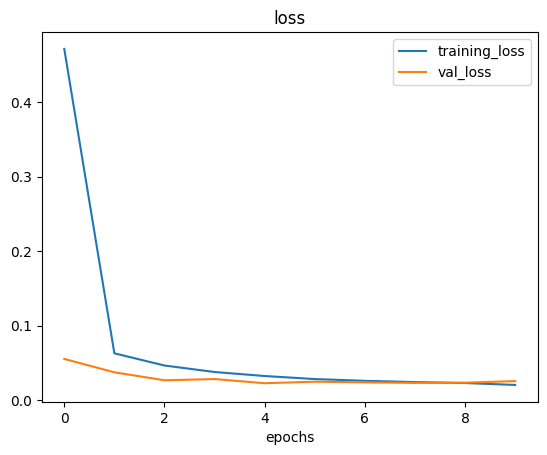

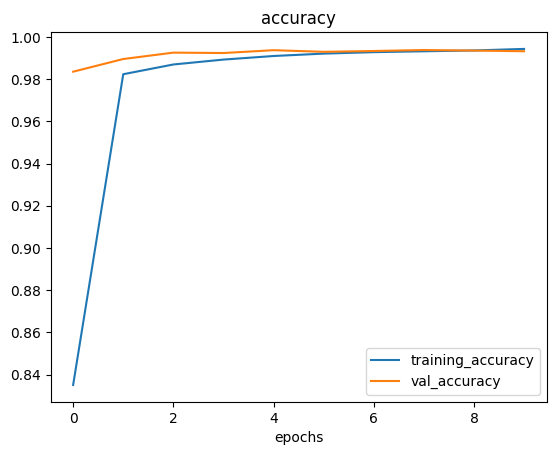

In [24]:
plot_loss_curves(history_custom)